In [1]:
import numpy as np
import pandas as pd
import os
import json
import pickle
import torch   
import copy 

from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting parameters
plt.rcParams.update({
"text.usetex":True,
"font.family":"sans-serif",
"font.serif":["Computer Modern Roman"]})
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 1

# User defined files and classes
import sys
sys.path.append('/Users/maitreyeesharma/WORKSPACE/PostDoc/Chemistry/SPIRAL/codes/RL/ReLMM/scripts/')

In [2]:
def read_gryffin(input_file='/Users/maitreyeesharma/WORKSPACE/PostDoc/Chemistry/SPIRAL/codes/RL/ReLMM/MHP_dataset/perovskites.pkl'):
    '''
    This function reads the perovskite dataset used in the GRYFFIN paper: https://doi.org/10.1063/5.0048164
    It does not need any inputs. 
    Inputs to the class for this case should be: 
    input_type='Gryffin',
    input_path='/Users/maitreyeesharma/WORKSPACE/PostDoc/EngChem/MatDisc_ML/datasets/',
    input_file='perovskites.pkl'
    '''

    lookup_df = pickle.load(open(input_file, 'rb'))
    perov_desc = pd.DataFrame(lookup_df, columns=['organic-homo',
                               'organic-lumo', 'organic-dipole', 'organic-atomization',
                               'organic-r_gyr', 'organic-total_mass', 'anion-electron_affinity',
                               'anion-ionization_energy', 'anion-mass', 'anion-electronegativity',
                               'cation-electron_affinity', 'cation-ionization_energy', 'cation-mass',
                               'cation-electronegativity'])

    XX = perov_desc
    HSE_gap_copy = copy.deepcopy(lookup_df.hse06.to_numpy())
    YY=HSE_gap_copy.reshape(-1,1)
    YY = -1.0*YY

    return XX, YY, perov_desc.columns

In [3]:
## Main Function
save_plot = False

# Reading the input json file with dataset filename and path information
with open('../inputs.json', "r") as f:
    input_dict = json.load(f)

run_folder = input_dict['RunFolder']
input_type = input_dict['InputType']
input_path = input_dict['InputPath']
input_file = input_dict['InputFile']
output_dir = input_dict['OutputDirectory']

# Create a new output directory if it does not exist
isExist = os.path.exists(output_dir)
if not isExist:
    os.makedirs(output_dir)
    print("The new directory is created!", output_dir)

X_data, Y_data, descriptors = read_gryffin(input_file=input_path+input_file)
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.1, random_state=0)


## Violin Plot

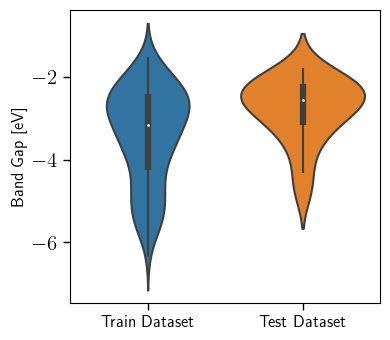

In [4]:
# Dataset parameters
total_num_features = len(descriptors)
train_dataset_size = len(Y_train)
test_dataset_size = len(Y_test)

data = pd.DataFrame({
    "Value": np.concatenate([Y_train.reshape(train_dataset_size), Y_test.reshape(test_dataset_size)]),
    "Group": ["Train Dataset"] * train_dataset_size + ["Test Dataset"] * test_dataset_size})

# Violin Plot
fig = plt.figure(figsize=(4,3.5))
sns.violinplot(x="Group", y="Value", data=data)
plt.ylabel('Band Gap [eV]')
plt.xlabel('')

# Adjust layout
plt.tight_layout()

if save_plot:
    plt.savefig(output_dir+
                '../figures/MHP_dataset_violin_plot.pdf',
                bbox_inches='tight', dpi=300) 

## PCC Plot

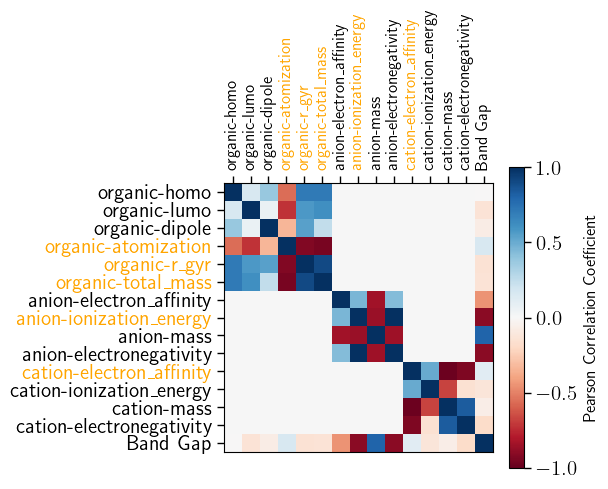

In [5]:
import scipy
import itertools

# Pearson correlation coefficients
def pearson_corr_coeff(x,y):

    rho_coeff=[]
    rho_coeff = scipy.stats.pearsonr(x, y)
    return rho_coeff.statistic

all_data = X_data
all_data['Band Gap'] = Y_data
pcc = []
for i in range(len(all_data.columns)):
    for j in range(len(all_data.columns)):
        pcc.append(pearson_corr_coeff(all_data[all_data.columns[i]],all_data[all_data.columns[j]]))
        
pcc_matrix = np.array(pcc,dtype=np.float32) 
pcc_matrix = np.reshape(pcc_matrix,(len(all_data.columns),len(all_data.columns)))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cax = ax.imshow(pcc_matrix,cmap='RdBu',vmin=-1, vmax=1)
ax.xaxis.tick_top()
ax.xaxis.set_ticks(list(itertools.chain(range(0,len(all_data.columns)))))
ax.xaxis.set_ticklabels(all_data.columns,rotation=90)
ax.yaxis.set_ticks(list(itertools.chain(range(0,len(all_data.columns)))))
ax.yaxis.set_ticklabels(all_data.columns)
id_tick_change_colour_list = [3,4,5,7,10]

for id_tick_change_colour in id_tick_change_colour_list:
    plt.setp(ax.get_xticklabels()[id_tick_change_colour], color='orange')
    plt.setp(ax.get_yticklabels()[id_tick_change_colour], color='orange')
    
fig.colorbar(cax,label='Pearson Correlation Coefficient', shrink=0.68)
plt.tight_layout()
if save_plot:
    plt.savefig(output_dir+'../figures/PCC_matrix-gryffin.pdf', bbox_inches='tight', dpi=300)
    

In [8]:
X_data

,organic-homo,organic-lumo,organic-dipole,organic-atomization,organic-r_gyr,organic-total_mass,anion-electron_affinity,anion-ionization_energy,anion-mass,anion-electronegativity,cation-electron_affinity,cation-ionization_energy,cation-mass,cation-electronegativity,Band Gap
0,-0.49721,-0.22400,1.3334,-1.725934,1.344149,59.092,3.401189,17.42282,18.998,4.0,1.232676,7.89940,72.63,2.01,-5.1528
1,-0.49721,-0.22400,1.3334,-1.725934,1.344149,59.092,3.612724,12.96764,35.450,3.0,1.232676,7.89940,72.63,2.01,-3.7624
2,-0.49721,-0.22400,1.3334,-1.725934,1.344149,59.092,3.363588,11.81381,79.904,2.8,1.232676,7.89940,72.63,2.01,-2.9861
3,-0.49721,-0.22400,1.3334,-1.725934,1.344149,59.092,3.059046,10.45126,126.900,2.5,1.232676,7.89940,72.63,2.01,-2.3129
4,-0.49721,-0.22400,1.3334,-1.725934,1.344149,59.092,3.401189,17.42282,18.998,4.0,1.112070,7.34390,118.71,1.90,-4.3173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-0.58397,-0.18158,0.8595,-2.045617,1.393929,60.120,3.059046,10.45126,126.900,2.5,1.112070,7.34390,118.71,1.90,-1.9374
188,-0.58397,-0.18158,0.8595,-2.045617,1.393929,60.120,3.401189,17.42282,18.998,4.0,0.356743,7.41666,207.20,2.33,-4.8213
189,-0.58397,-0.18158,0.8595,-2.045617,1.393929,60.120,3.612724,12.96764,35.450,3.0,0.356743,7.41666,207.20,2.33,-3.5090
190,-0.58397,-0.18158,0.8595,-2.045617,1.393929,60.120,3.363588,11.81381,79.904,2.8,0.356743,7.41666,207.20,2.33,-2.9537


## Scatter plots

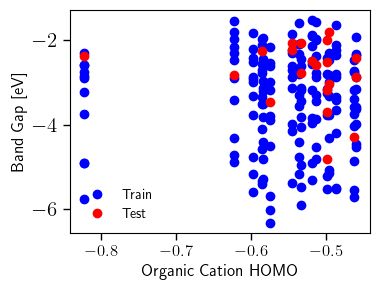

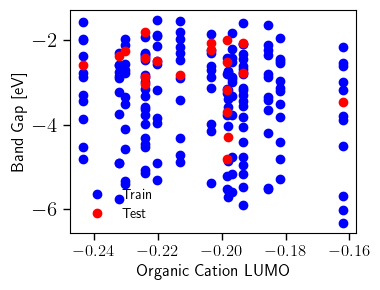

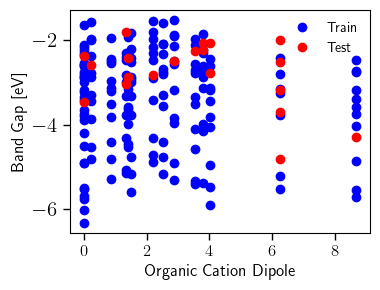

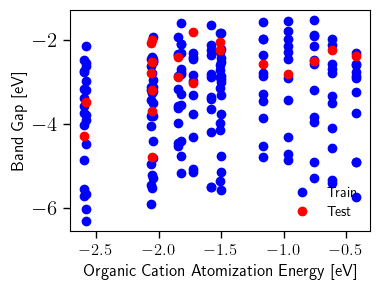

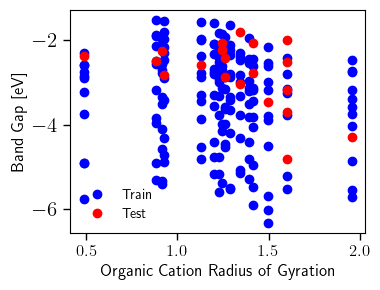

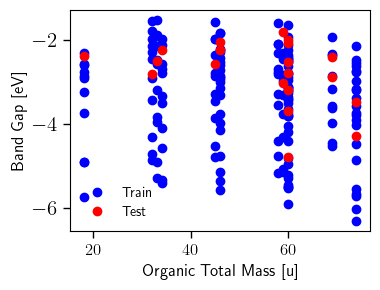

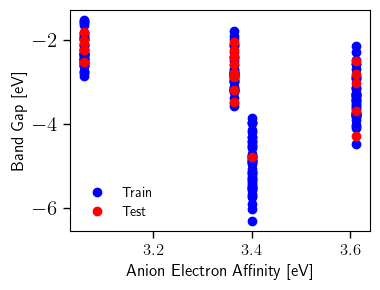

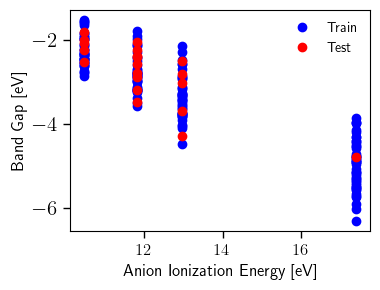

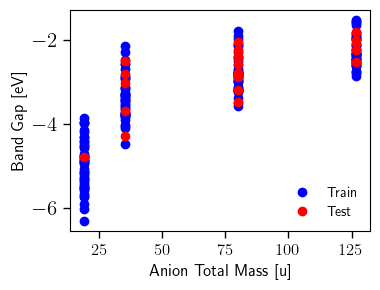

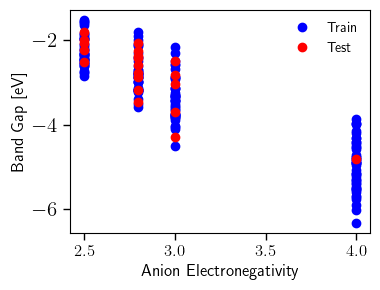

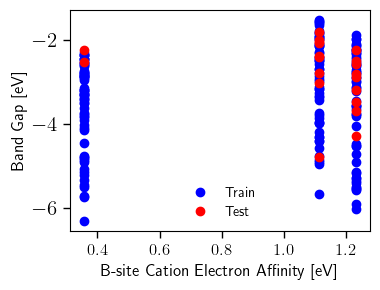

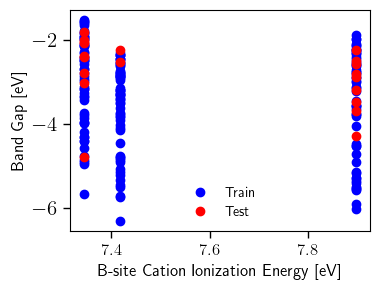

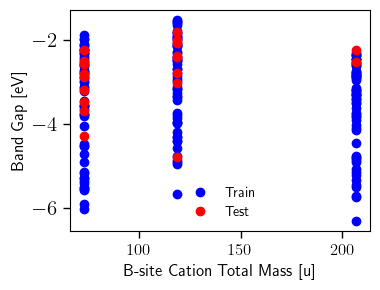

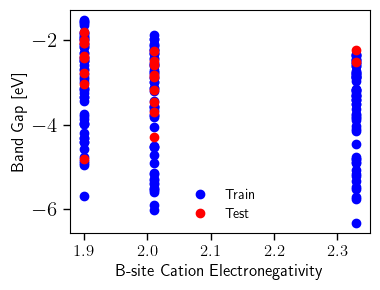

In [6]:
xlabels = ['Organic Cation HOMO', 'Organic Cation LUMO', 'Organic Cation Dipole',
          'Organic Cation Atomization Energy [eV]', 'Organic Cation Radius of Gyration',
          'Organic Total Mass [u]', 'Anion Electron Affinity [eV]', 'Anion Ionization Energy [eV]',
          'Anion Total Mass [u]', 'Anion Electronegativity', 'B-site Cation Electron Affinity [eV]', 
          'B-site Cation Ionization Energy [eV]', 'B-site Cation Total Mass [u]', 
          'B-site Cation Electronegativity']

save_plot = False
for i in range(len(descriptors)):
    fig = plt.figure(figsize=(3.9, 3))
    ax = fig.add_subplot(111)
    ax.plot(X_train[descriptors[i]],Y_train,'ob',label='Train')
    ax.plot(X_test[descriptors[i]],Y_test,'or',label='Test')
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel('Band Gap [eV]')
    # ax.xaxis.set_ticks([11,12,13,14,15,16,17])
    plt.legend(frameon=False)
    plt.tight_layout()
    if save_plot:
        plt.savefig(output_dir+'../figures/'+descriptors[i]+'-BandGap.pdf', bbox_inches='tight', dpi=300)
    

## Fit for Anion IE

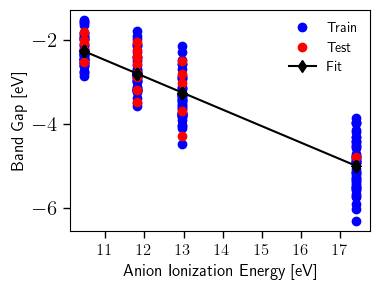

In [7]:
def linear_model(ppt, a, b):
    y = a + b*ppt
    return y

parameters, covariance = curve_fit(linear_model, X_data['anion-ionization_energy'], Y_data.reshape(192))
fit_a = parameters[0]
fit_b = parameters[1]

fit_bandgap = linear_model(X_data['anion-ionization_energy'], fit_a, fit_b)

fig = plt.figure(figsize=(3.9, 3))
ax = fig.add_subplot(111)
ax.plot(X_train['anion-ionization_energy'],Y_train,'ob',label='Train')
ax.plot(X_test['anion-ionization_energy'],Y_test,'or',label='Test')
ax.plot(X_data['anion-ionization_energy'],fit_bandgap,'-dk',label='Fit')

ax.set_xlabel('Anion Ionization Energy [eV]')
ax.set_ylabel('Band Gap [eV]')
ax.xaxis.set_ticks([11,12,13,14,15,16,17])
plt.legend(frameon=False)
plt.tight_layout()
